In [1]:
import os
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import io
import tensorflow as tf
import keras
from keras import Sequential, layers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import ResNet50, EfficientNetV2L
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import h5py
from tqdm import tqdm

In [2]:
os.environ['KERAS_BACKEND']='tensorflow'
np.random.seed(0)

In [3]:
keras.models.load_model('skin-cancer-classification-model.keras')

In [3]:
raw_train=pd.read_csv(r"C:\Users\subha\OneDrive\Desktop\train-metadata.csv")

In [4]:
raw_train.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [5]:
raw_train['target'].value_counts()

0    400666
1       393
Name: target, dtype: int64

In [6]:
f=h5py.File(r"C:\Users\subha\OneDrive\Desktop\train-image.hdf5", 'r')

In [7]:
key=list(f.keys())[0]
key

'ISIC_0015670'

In [8]:
type(f[key])

h5py._hl.dataset.Dataset

In [9]:
data=np.array(f[key])

In [10]:
img=Image.open(io.BytesIO(data))

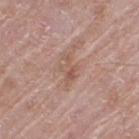

In [11]:
img

In [12]:
img.size

(139, 139)

In [13]:
f.close()

In [14]:
df=raw_train.copy()

In [15]:
np.random.seed(0)
df_normal=df[df['target']==0].sample(frac=0.001)
df_can=df[df['target']==1]
df=pd.concat([df_normal,df_can])

In [16]:
df['target'].value_counts()

0    401
1    393
Name: target, dtype: int64

In [17]:
df.duplicated().sum()

0

In [18]:
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
362145,ISIC_9040269,0,IP_0810302,30.0,male,posterior torso,14.20,TBP tile: close-up,3D: XP,24.865746,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,91.781771
329166,ISIC_8229992,0,IP_7205082,65.0,female,anterior torso,3.67,TBP tile: close-up,3D: white,33.632050,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
382103,ISIC_9527705,0,IP_4379891,60.0,female,posterior torso,2.66,TBP tile: close-up,3D: XP,19.909537,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.853730
374094,ISIC_9331106,0,IP_3863759,35.0,male,posterior torso,3.30,TBP tile: close-up,3D: XP,14.759865,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
376789,ISIC_9397210,0,IP_1039996,40.0,male,posterior torso,3.01,TBP tile: close-up,3D: white,19.414560,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999714


In [19]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [20]:
df.drop(['isic_id','patient_id','image_type','tbp_tile_type','attribution','copyright_license'], axis=1, inplace=True)

In [21]:
df.drop(df.loc[:, 'lesion_id':], axis=1, inplace=True)

In [22]:
df.shape

(794, 39)

In [23]:
df.drop(['tbp_lv_location', 'tbp_lv_location_simple'], axis=1, inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 362145 to 400922
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   target                       794 non-null    int64  
 1   age_approx                   789 non-null    float64
 2   sex                          770 non-null    object 
 3   anatom_site_general          789 non-null    object 
 4   clin_size_long_diam_mm       794 non-null    float64
 5   tbp_lv_A                     794 non-null    float64
 6   tbp_lv_Aext                  794 non-null    float64
 7   tbp_lv_B                     794 non-null    float64
 8   tbp_lv_Bext                  794 non-null    float64
 9   tbp_lv_C                     794 non-null    float64
 10  tbp_lv_Cext                  794 non-null    float64
 11  tbp_lv_H                     794 non-null    float64
 12  tbp_lv_Hext                  794 non-null    float64
 13  tbp_lv_L    

<Axes: xlabel='sex', ylabel='count'>

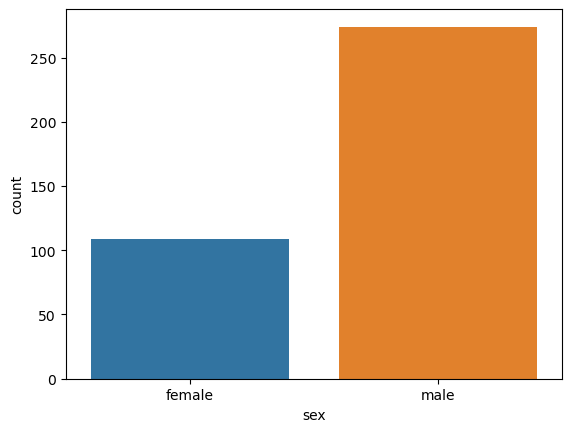

In [25]:
sns.countplot(x='sex', data=df[df['target']==1])

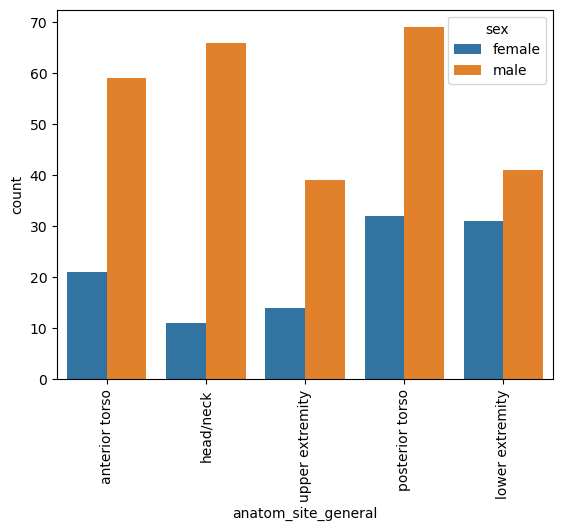

In [26]:
sns.countplot(df[df['target']==1], x='anatom_site_general', hue='sex')
plt.xticks(rotation=90)
plt.show()

In [27]:
df['sex']=df['sex'].fillna('male')

In [28]:
df['anatom_site_general'].value_counts()

posterior torso    229
anterior torso     174
lower extremity    173
upper extremity    123
head/neck           90
Name: anatom_site_general, dtype: int64

In [29]:
df['anatom_site_general']=df['anatom_site_general'].fillna('posterior torso')

In [30]:
y=df['target']
x=df.drop(['target'], axis=1)

In [31]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=0)
x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [32]:
x_train.head(2)

,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
31794,60.0,male,posterior torso,3.70,19.354396,12.134801,36.977768,32.85741,41.73665,35.026601,...,3.738948,10.937071,1.217105,2.742538,2.735680,0.146552,95,-136.595459,1299.162598,-68.263184
27945,45.0,female,posterior torso,3.74,20.354720,17.180000,23.287570,27.05198,30.92936,32.046240,...,5.420758,11.177810,1.604284,5.848051,1.759518,0.188284,50,-84.250580,1116.659000,183.958600


In [34]:
print(y_train.mean(), y_val.mean(), y_test.mean())

0.5137795275590551 0.41732283464566927 0.4968553459119497


In [35]:
clf=CatBoostClassifier(iterations=100, random_seed=0, loss_function='Logloss',  nan_mode='Max', custom_metric=['AUC'])

In [36]:
base_model=clf.fit(x_train, y_train,
                  cat_features=['sex', 'anatom_site_general'],
                  eval_set=(x_val, y_val),
                  )

Learning rate set to 0.072989
0:	learn: 0.6463283	test: 0.6549347	best: 0.6549347 (0)	total: 258ms	remaining: 25.5s
1:	learn: 0.6087179	test: 0.6265131	best: 0.6265131 (1)	total: 311ms	remaining: 15.2s
2:	learn: 0.5708937	test: 0.5898016	best: 0.5898016 (2)	total: 389ms	remaining: 12.6s
3:	learn: 0.5377592	test: 0.5657380	best: 0.5657380 (3)	total: 463ms	remaining: 11.1s
4:	learn: 0.5082911	test: 0.5449092	best: 0.5449092 (4)	total: 542ms	remaining: 10.3s
5:	learn: 0.4782262	test: 0.5200326	best: 0.5200326 (5)	total: 607ms	remaining: 9.51s
6:	learn: 0.4539672	test: 0.4925269	best: 0.4925269 (6)	total: 679ms	remaining: 9.02s
7:	learn: 0.4339383	test: 0.4829619	best: 0.4829619 (7)	total: 742ms	remaining: 8.54s
8:	learn: 0.4190644	test: 0.4688404	best: 0.4688404 (8)	total: 812ms	remaining: 8.21s
9:	learn: 0.4018045	test: 0.4546006	best: 0.4546006 (9)	total: 888ms	remaining: 7.99s
10:	learn: 0.3843565	test: 0.4417162	best: 0.4417162 (10)	total: 965ms	remaining: 7.81s
11:	learn: 0.3655151	t

97:	learn: 0.0805909	test: 0.2943147	best: 0.2938860 (91)	total: 7.32s	remaining: 149ms
98:	learn: 0.0796782	test: 0.2936516	best: 0.2936516 (98)	total: 7.39s	remaining: 74.6ms
99:	learn: 0.0786344	test: 0.2932901	best: 0.2932901 (99)	total: 7.46s	remaining: 0us

bestTest = 0.2932900906
bestIteration = 99



In [37]:
from sklearn.metrics import roc_auc_score
y_pred=base_model.predict(x_test)
print(roc_auc_score(y_test, y_pred))

0.918354430379747


In [33]:
df=raw_train.copy()

In [34]:
np.random.seed(0)
df_normal=df[df['target']==0].sample(frac=0.01)
df_can=df[df['target']==1]
df=pd.concat([df_normal,df_can])

In [35]:
df_can=df[df['target']==1]
df_can.shape

(393, 55)

In [36]:
image=[]
size=120
with h5py.File(r"C:\Users\subha\OneDrive\Desktop\train-image.hdf5", 'r') as f:
    for key in tqdm(list(f.keys())):
        if key in np.array(df['isic_id']):
            img=Image.open(io.BytesIO(np.array(f[key])))
            img=img.resize((size, size))
            image.append(np.array(img))

100%|██████████| 401059/401059 [04:57<00:00, 1347.61it/s]


In [37]:
len(image)

4400

In [38]:
datagen=ImageDataGenerator(vertical_flip=True, horizontal_flip=True, rotation_range=180, fill_mode='nearest')

In [39]:
with h5py.File(r"C:\Users\subha\OneDrive\Desktop\train-image.hdf5", 'r') as f:
    for key in tqdm(list(f.keys())):
        if key in np.array(df_can['isic_id']):
            img=Image.open(io.BytesIO(np.array(f[key])))
            img=img.resize((120,120))
            img=np.array(img)
            img=img.reshape((1,)+img.shape)
            i=0
            for im in datagen.flow(img, batch_size=1):
                image.append(im[0].astype('uint8'))
                if i>9:
                    break
                i+=1

100%|██████████| 401059/401059 [00:50<00:00, 7883.64it/s] 


In [40]:
len(image)

8723

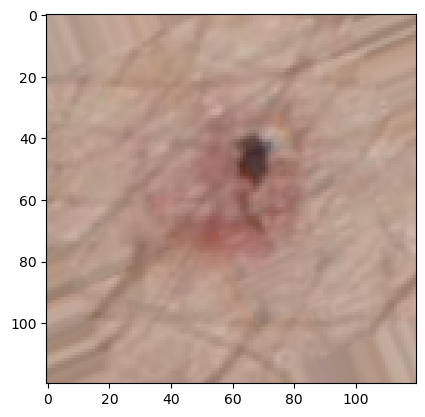

In [41]:
plt.imshow(image[-30])

In [42]:
image[-1].shape

(120, 120, 3)

In [43]:
Y=np.array(df['target'])

In [44]:
Y=Y.tolist()
for i in range(len(image)-4400):
    Y.append(1)
y=np.array(Y)    

In [45]:
x_train,x_test,y_train,y_test=train_test_split(image, y, test_size=0.2, random_state=0)
x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [46]:
x_train[-1].shape

(120, 120, 3)

In [47]:
print(np.mean(y_train), np.mean(y_val), np.mean(y_test))

0.5383375134360444 0.5386819484240688 0.5495702005730659


In [48]:
metrics=[
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='pr')
]

In [49]:
early_stopping=keras.callbacks.EarlyStopping(patience=2, verbose=1)

In [50]:
effnetbase=EfficientNetV2L(include_top=False, weights='imagenet', input_shape=(size,size,3), pooling='max')

In [51]:
for layer in effnetbase.layers:
    layer.trainable=False

In [53]:
base=effnetbase.output
base=layers.Flatten()(base)
base=layers.Dense(512, activation='relu')(base)
base=layers.Dropout(0.2)(base)
output=layers.Dense(1, activation='sigmoid')(base)
model=keras.Model(inputs=effnetbase.input, outputs=output)

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 120, 120, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 60, 60, 32)           864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 60, 60, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                         

 2D)                                                                [0]']                         
                                                                                                  
 block2a_project_bn (BatchN  (None, 30, 30, 64)           256       ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 30, 30, 256)          147456    ['block2a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block2b_expand_bn (BatchNo  (None, 30, 30, 256)          1024      ['block2b_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                     'block2d_add[0][0]']         
                                                                                                  
 block2f_expand_conv (Conv2  (None, 30, 30, 256)          147456    ['block2e_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2f_expand_bn (BatchNo  (None, 30, 30, 256)          1024      ['block2f_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2f_expand_activation   (None, 30, 30, 256)          0         ['block2f_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block3c_expand_activation   (None, 15, 15, 384)          0         ['block3c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3c_project_conv (Conv  (None, 15, 15, 96)           36864     ['block3c_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3c_project_bn (BatchN  (None, 15, 15, 96)           384       ['block3c_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3c_drop (Dropout)      (None, 15, 15, 96)           0         ['block3c_project_bn[0][0]']  
          

 block3g_project_conv (Conv  (None, 15, 15, 96)           36864     ['block3g_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3g_project_bn (BatchN  (None, 15, 15, 96)           384       ['block3g_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3g_drop (Dropout)      (None, 15, 15, 96)           0         ['block3g_project_bn[0][0]']  
                                                                                                  
 block3g_add (Add)           (None, 15, 15, 96)           0         ['block3g_drop[0][0]',        
                                                                     'block3f_add[0][0]']         
          

 ormalization)                                                                                    
                                                                                                  
 block4b_drop (Dropout)      (None, 8, 8, 192)            0         ['block4b_project_bn[0][0]']  
                                                                                                  
 block4b_add (Add)           (None, 8, 8, 192)            0         ['block4b_drop[0][0]',        
                                                                     'block4a_project_bn[0][0]']  
                                                                                                  
 block4c_expand_conv (Conv2  (None, 8, 8, 768)            147456    ['block4b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4c_e

 block4d_project_bn (BatchN  (None, 8, 8, 192)            768       ['block4d_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4d_drop (Dropout)      (None, 8, 8, 192)            0         ['block4d_project_bn[0][0]']  
                                                                                                  
 block4d_add (Add)           (None, 8, 8, 192)            0         ['block4d_drop[0][0]',        
                                                                     'block4c_add[0][0]']         
                                                                                                  
 block4e_expand_conv (Conv2  (None, 8, 8, 768)            147456    ['block4d_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block4f_project_bn (BatchN  (None, 8, 8, 192)            768       ['block4f_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4f_drop (Dropout)      (None, 8, 8, 192)            0         ['block4f_project_bn[0][0]']  
                                                                                                  
 block4f_add (Add)           (None, 8, 8, 192)            0         ['block4f_drop[0][0]',        
                                                                     'block4e_add[0][0]']         
                                                                                                  
 block4g_expand_conv (Conv2  (None, 8, 8, 768)            147456    ['block4f_add[0][0]']         
 D)       

 2D)                                                                                              
                                                                                                  
 block4h_project_bn (BatchN  (None, 8, 8, 192)            768       ['block4h_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4h_drop (Dropout)      (None, 8, 8, 192)            0         ['block4h_project_bn[0][0]']  
                                                                                                  
 block4h_add (Add)           (None, 8, 8, 192)            0         ['block4h_drop[0][0]',        
                                                                     'block4g_add[0][0]']         
                                                                                                  
 block4i_e

 block4j_project_conv (Conv  (None, 8, 8, 192)            147456    ['block4j_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4j_project_bn (BatchN  (None, 8, 8, 192)            768       ['block4j_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4j_drop (Dropout)      (None, 8, 8, 192)            0         ['block4j_project_bn[0][0]']  
                                                                                                  
 block4j_add (Add)           (None, 8, 8, 192)            0         ['block4j_drop[0][0]',        
                                                                     'block4i_add[0][0]']         
          

 ormalization)                                                                                    
                                                                                                  
 block5b_drop (Dropout)      (None, 8, 8, 224)            0         ['block5b_project_bn[0][0]']  
                                                                                                  
 block5b_add (Add)           (None, 8, 8, 224)            0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 8, 8, 1344)           301056    ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_e

 block5d_project_bn (BatchN  (None, 8, 8, 224)            896       ['block5d_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5d_drop (Dropout)      (None, 8, 8, 224)            0         ['block5d_project_bn[0][0]']  
                                                                                                  
 block5d_add (Add)           (None, 8, 8, 224)            0         ['block5d_drop[0][0]',        
                                                                     'block5c_add[0][0]']         
                                                                                                  
 block5e_expand_conv (Conv2  (None, 8, 8, 1344)           301056    ['block5d_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block5f_project_bn (BatchN  (None, 8, 8, 224)            896       ['block5f_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5f_drop (Dropout)      (None, 8, 8, 224)            0         ['block5f_project_bn[0][0]']  
                                                                                                  
 block5f_add (Add)           (None, 8, 8, 224)            0         ['block5f_drop[0][0]',        
                                                                     'block5e_add[0][0]']         
                                                                                                  
 block5g_expand_conv (Conv2  (None, 8, 8, 1344)           301056    ['block5f_add[0][0]']         
 D)       

 2D)                                                                                              
                                                                                                  
 block5h_project_bn (BatchN  (None, 8, 8, 224)            896       ['block5h_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5h_drop (Dropout)      (None, 8, 8, 224)            0         ['block5h_project_bn[0][0]']  
                                                                                                  
 block5h_add (Add)           (None, 8, 8, 224)            0         ['block5h_drop[0][0]',        
                                                                     'block5g_add[0][0]']         
                                                                                                  
 block5i_e

 block5j_project_conv (Conv  (None, 8, 8, 224)            301056    ['block5j_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5j_project_bn (BatchN  (None, 8, 8, 224)            896       ['block5j_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5j_drop (Dropout)      (None, 8, 8, 224)            0         ['block5j_project_bn[0][0]']  
                                                                                                  
 block5j_add (Add)           (None, 8, 8, 224)            0         ['block5j_drop[0][0]',        
                                                                     'block5i_add[0][0]']         
          

                                                                                                  
 block5l_project_conv (Conv  (None, 8, 8, 224)            301056    ['block5l_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5l_project_bn (BatchN  (None, 8, 8, 224)            896       ['block5l_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5l_drop (Dropout)      (None, 8, 8, 224)            0         ['block5l_project_bn[0][0]']  
                                                                                                  
 block5l_add (Add)           (None, 8, 8, 224)            0         ['block5l_drop[0][0]',        
          

 y)                                                                  'block5n_se_expand[0][0]']   
                                                                                                  
 block5n_project_conv (Conv  (None, 8, 8, 224)            301056    ['block5n_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5n_project_bn (BatchN  (None, 8, 8, 224)            896       ['block5n_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5n_drop (Dropout)      (None, 8, 8, 224)            0         ['block5n_project_bn[0][0]']  
                                                                                                  
 block5n_a

 block5p_se_excite (Multipl  (None, 8, 8, 1344)           0         ['block5p_activation[0][0]',  
 y)                                                                  'block5p_se_expand[0][0]']   
                                                                                                  
 block5p_project_conv (Conv  (None, 8, 8, 224)            301056    ['block5p_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5p_project_bn (BatchN  (None, 8, 8, 224)            896       ['block5p_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5p_drop (Dropout)      (None, 8, 8, 224)            0         ['block5p_project_bn[0][0]']  
          

                                                                                                  
 block5r_se_excite (Multipl  (None, 8, 8, 1344)           0         ['block5r_activation[0][0]',  
 y)                                                                  'block5r_se_expand[0][0]']   
                                                                                                  
 block5r_project_conv (Conv  (None, 8, 8, 224)            301056    ['block5r_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5r_project_bn (BatchN  (None, 8, 8, 224)            896       ['block5r_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5r_d

 block6a_se_expand (Conv2D)  (None, 1, 1, 1344)           76608     ['block6a_se_reduce[0][0]']   
                                                                                                  
 block6a_se_excite (Multipl  (None, 4, 4, 1344)           0         ['block6a_activation[0][0]',  
 y)                                                                  'block6a_se_expand[0][0]']   
                                                                                                  
 block6a_project_conv (Conv  (None, 4, 4, 384)            516096    ['block6a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block6a_project_bn (BatchN  (None, 4, 4, 384)            1536      ['block6a_project_conv[0][0]']
 ormalization)                                                                                    
          

                                                                                                  
 block6c_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6c_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block6c_project_bn (BatchN  (None, 4, 4, 384)            1536      ['block6c_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block6c_drop (Dropout)      (None, 4, 4, 384)            0         ['block6c_project_bn[0][0]']  
                                                                                                  
 block6c_add (Add)           (None, 4, 4, 384)            0         ['block6c_drop[0][0]',        
          

 y)                                                                  'block6e_se_expand[0][0]']   
                                                                                                  
 block6e_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6e_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block6e_project_bn (BatchN  (None, 4, 4, 384)            1536      ['block6e_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block6e_drop (Dropout)      (None, 4, 4, 384)            0         ['block6e_project_bn[0][0]']  
                                                                                                  
 block6e_a

 block6g_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6g_activation[0][0]',  
 y)                                                                  'block6g_se_expand[0][0]']   
                                                                                                  
 block6g_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6g_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block6g_project_bn (BatchN  (None, 4, 4, 384)            1536      ['block6g_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block6g_drop (Dropout)      (None, 4, 4, 384)            0         ['block6g_project_bn[0][0]']  
          

                                                                                                  
 block6i_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6i_activation[0][0]',  
 y)                                                                  'block6i_se_expand[0][0]']   
                                                                                                  
 block6i_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6i_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block6i_project_bn (BatchN  (None, 4, 4, 384)            1536      ['block6i_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block6i_d

 block6k_se_expand (Conv2D)  (None, 1, 1, 2304)           223488    ['block6k_se_reduce[0][0]']   
                                                                                                  
 block6k_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6k_activation[0][0]',  
 y)                                                                  'block6k_se_expand[0][0]']   
                                                                                                  
 block6k_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6k_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block6k_project_bn (BatchN  (None, 4, 4, 384)            1536      ['block6k_project_conv[0][0]']
 ormalization)                                                                                    
          

                                                                                                  
 block6m_se_expand (Conv2D)  (None, 1, 1, 2304)           223488    ['block6m_se_reduce[0][0]']   
                                                                                                  
 block6m_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6m_activation[0][0]',  
 y)                                                                  'block6m_se_expand[0][0]']   
                                                                                                  
 block6m_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6m_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block6m_project_bn (BatchN  (None, 4, 4, 384)            1536      ['block6m_project_conv[0][0]']
 ormalizat

 block6o_se_reduce (Conv2D)  (None, 1, 1, 96)             221280    ['block6o_se_reshape[0][0]']  
                                                                                                  
 block6o_se_expand (Conv2D)  (None, 1, 1, 2304)           223488    ['block6o_se_reduce[0][0]']   
                                                                                                  
 block6o_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6o_activation[0][0]',  
 y)                                                                  'block6o_se_expand[0][0]']   
                                                                                                  
 block6o_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6o_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block6o_p

                                                                                                  
 block6q_se_reduce (Conv2D)  (None, 1, 1, 96)             221280    ['block6q_se_reshape[0][0]']  
                                                                                                  
 block6q_se_expand (Conv2D)  (None, 1, 1, 2304)           223488    ['block6q_se_reduce[0][0]']   
                                                                                                  
 block6q_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6q_activation[0][0]',  
 y)                                                                  'block6q_se_expand[0][0]']   
                                                                                                  
 block6q_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6q_se_excite[0][0]']   
 2D)                                                                                              
          

 e)                                                                                               
                                                                                                  
 block6s_se_reduce (Conv2D)  (None, 1, 1, 96)             221280    ['block6s_se_reshape[0][0]']  
                                                                                                  
 block6s_se_expand (Conv2D)  (None, 1, 1, 2304)           223488    ['block6s_se_reduce[0][0]']   
                                                                                                  
 block6s_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6s_activation[0][0]',  
 y)                                                                  'block6s_se_expand[0][0]']   
                                                                                                  
 block6s_project_conv (Conv  (None, 4, 4, 384)            884736    ['block6s_se_excite[0][0]']   
 2D)      

 block6u_se_reshape (Reshap  (None, 1, 1, 2304)           0         ['block6u_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6u_se_reduce (Conv2D)  (None, 1, 1, 96)             221280    ['block6u_se_reshape[0][0]']  
                                                                                                  
 block6u_se_expand (Conv2D)  (None, 1, 1, 2304)           223488    ['block6u_se_reduce[0][0]']   
                                                                                                  
 block6u_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6u_activation[0][0]',  
 y)                                                                  'block6u_se_expand[0][0]']   
                                                                                                  
 block6u_p

                                                                                                  
 block6w_se_reshape (Reshap  (None, 1, 1, 2304)           0         ['block6w_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6w_se_reduce (Conv2D)  (None, 1, 1, 96)             221280    ['block6w_se_reshape[0][0]']  
                                                                                                  
 block6w_se_expand (Conv2D)  (None, 1, 1, 2304)           223488    ['block6w_se_reduce[0][0]']   
                                                                                                  
 block6w_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6w_activation[0][0]',  
 y)                                                                  'block6w_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block6y_se_reshape (Reshap  (None, 1, 1, 2304)           0         ['block6y_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6y_se_reduce (Conv2D)  (None, 1, 1, 96)             221280    ['block6y_se_reshape[0][0]']  
                                                                                                  
 block6y_se_expand (Conv2D)  (None, 1, 1, 2304)           223488    ['block6y_se_reduce[0][0]']   
                                                                                                  
 block6y_se_excite (Multipl  (None, 4, 4, 2304)           0         ['block6y_activation[0][0]',  
 y)       

                                                                                                  
 block7b_se_reduce (Conv2D)  (None, 1, 1, 160)            614560    ['block7b_se_reshape[0][0]']  
                                                                                                  
 block7b_se_expand (Conv2D)  (None, 1, 1, 3840)           618240    ['block7b_se_reduce[0][0]']   
                                                                                                  
 block7b_se_excite (Multipl  (None, 4, 4, 3840)           0         ['block7b_activation[0][0]',  
 y)                                                                  'block7b_se_expand[0][0]']   
                                                                                                  
 block7b_project_conv (Conv  (None, 4, 4, 640)            2457600   ['block7b_se_excite[0][0]']   
 2D)                                                                                              
          

 e)                                                                                               
                                                                                                  
 block7d_se_reduce (Conv2D)  (None, 1, 1, 160)            614560    ['block7d_se_reshape[0][0]']  
                                                                                                  
 block7d_se_expand (Conv2D)  (None, 1, 1, 3840)           618240    ['block7d_se_reduce[0][0]']   
                                                                                                  
 block7d_se_excite (Multipl  (None, 4, 4, 3840)           0         ['block7d_activation[0][0]',  
 y)                                                                  'block7d_se_expand[0][0]']   
                                                                                                  
 block7d_project_conv (Conv  (None, 4, 4, 640)            2457600   ['block7d_se_excite[0][0]']   
 2D)      

 block7f_se_reshape (Reshap  (None, 1, 1, 3840)           0         ['block7f_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block7f_se_reduce (Conv2D)  (None, 1, 1, 160)            614560    ['block7f_se_reshape[0][0]']  
                                                                                                  
 block7f_se_expand (Conv2D)  (None, 1, 1, 3840)           618240    ['block7f_se_reduce[0][0]']   
                                                                                                  
 block7f_se_excite (Multipl  (None, 4, 4, 3840)           0         ['block7f_activation[0][0]',  
 y)                                                                  'block7f_se_expand[0][0]']   
                                                                                                  
 block7f_p

Total params: 118403233 (451.67 MB)
Trainable params: 656385 (2.50 MB)
Non-trainable params: 117746848 (449.17 MB)
__________________________________________________________________________________________________


In [55]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=metrics
)

In [56]:
cnn=model.fit(
    np.array(x_train), y_train,
    batch_size=500,
    epochs=5,
    callbacks=[early_stopping],
    validation_data=(np.array(x_val), y_val),
    verbose=1
)

Epoch 1/5
12/12 [==============================] - 9321s 792s/step - loss: 2.2064 - accuracy: 0.6937 - auc: 0.6973 - prc: 0.7263 - val_loss: 0.5690 - val_accuracy: 0.7701 - val_auc: 0.9107 - val_prc: 0.9409
Epoch 2/5
12/12 [==============================] - 4763s 403s/step - loss: 0.4362 - accuracy: 0.8087 - auc: 0.8790 - prc: 0.9091 - val_loss: 0.3789 - val_accuracy: 0.8539 - val_auc: 0.9179 - val_prc: 0.9460
Epoch 3/5
12/12 [==============================] - 32286s 2902s/step - loss: 0.3680 - accuracy: 0.8395 - auc: 0.9080 - prc: 0.9358 - val_loss: 0.3669 - val_accuracy: 0.8560 - val_auc: 0.9225 - val_prc: 0.9486
Epoch 4/5
12/12 [==============================] - 7123s 618s/step - loss: 0.3543 - accuracy: 0.8511 - auc: 0.9121 - prc: 0.9403 - val_loss: 0.3250 - val_accuracy: 0.8696 - val_auc: 0.9203 - val_prc: 0.9485
Epoch 5/5
12/12 [==============================] - 10055s 874s/step - loss: 0.3930 - accuracy: 0.8382 - auc: 0.8995 - prc: 0.9281 - val_loss: 0.4780 - val_accuracy: 0.767

In [61]:
model.save('skin-cancer-classification-model.keras')

In [70]:
model.evaluate(np.array(x_test), y_test, batch_size=100)

18/18 [==============================] - 1449s 80s/step - loss: 0.4421 - accuracy: 0.8006 - auc: 0.9318 - prc: 0.9532


[0.442078173160553, 0.8005730509757996, 0.9317501187324524, 0.9531890749931335]

In [73]:
pred=model.predict(np.array(x_test))

55/55 [==============================] - 1700s 31s/step


In [81]:
fpr, tpr, _=roc_curve(y_test, pred)

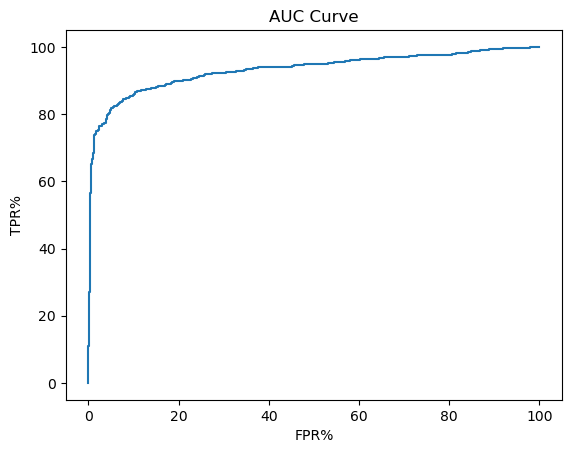

In [82]:
plt.plot(100*fpr, 100*tpr)
plt.title('AUC Curve')
plt.xlabel('FPR%')
plt.ylabel('TPR%')
plt.show()

In [83]:
precision, recall, _=precision_recall_curve(y_test, pred)

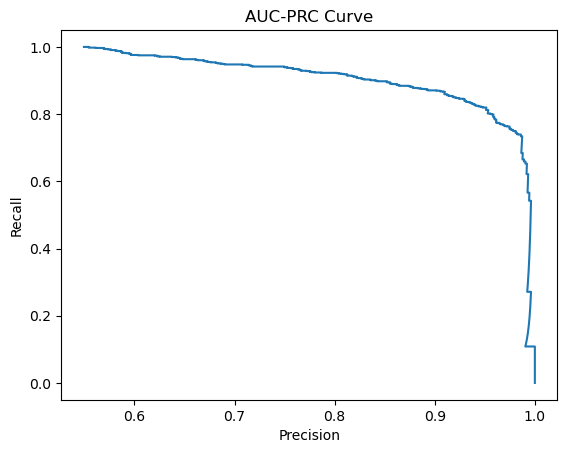

In [84]:
plt.plot(precision, recall)
plt.title('AUC-PRC Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

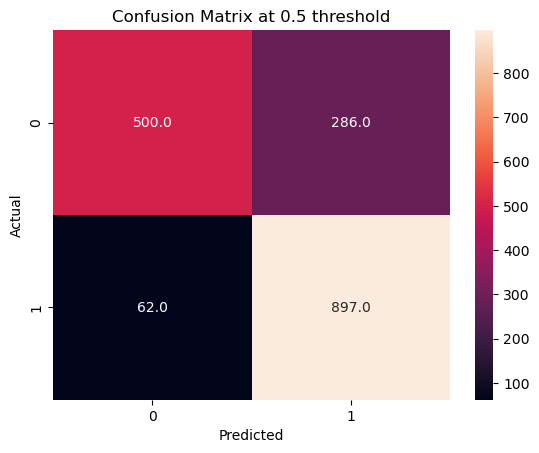

In [94]:
cm=confusion_matrix(y_test, pred>0.5)
sns.heatmap(cm, annot=True, fmt='.1f')
plt.title('Confusion Matrix at 0.5 threshold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [96]:
image=[]
size=120
with h5py.File(r"C:\Users\subha\OneDrive\Desktop\test-image.hdf5", 'r') as f:
    for key in tqdm(list(f.keys())):
        img=Image.open(io.BytesIO(np.array(f[key])))
        img=img.resize((size, size))
        image.append(np.array(img))

100%|██████████| 3/3 [00:00<00:00, 192.00it/s]


In [98]:
len(image)

3

In [100]:
image[0].shape

(120, 120, 3)

In [102]:
pred=model.predict(np.array(image))

1/1 [==============================] - 3s 3s/step


In [103]:
sub=pd.read_csv(r"C:\Users\subha\OneDrive\Desktop\sample_submission.csv")

In [104]:
sub

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


In [116]:
pred=pd.DataFrame(pred, columns=['target'])

In [117]:
sub['target']=pred

In [118]:
sub

,isic_id,target
0,ISIC_0015657,0.213965
1,ISIC_0015729,0.305060
2,ISIC_0015740,0.390526


In [119]:
sub.to_csv(r"C:\Users\subha\OneDrive\Desktop\sample_submission.csv", mode='w', index=False)